In [1]:
#!pip install torch torchvision
#!pip install albumentations

In [1]:
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor, Compose
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import albumentations as A

import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
import time
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
plt.style.use('ggplot')


/home/dante/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#git clone https://github.com/WongKinYiu/yolov7

# Parameters

In [2]:

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 60 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory

TRAIN_DIR = 'cacao/train'
# validation images and XML files directory
VALID_DIR = 'cacao/valid'

# classes: 0 index is reserved for background

# classes: 0 index is reserved for background
CLASSES = [
    'background', 'Fitoftora', 'Monilia', 'Sana'
]
NUM_CLASSES = 4


# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
OUT_DIR = './outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [13]:
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model


In [10]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [11]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

# Data

In [13]:

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [14]:

class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        #self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        #print("1")
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
        
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmax = min(xmax, image_width)
            ymax = min(ymax, image_height)
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            # xmin_final = min((xmin/image_width)*self.width, 1.)
            # xmax_final = min((xmax/image_width)*self.width, 1.)
            # ymin_final = min((ymin/image_height)*self.height, 1.)
            # yamx_final = min((ymax/image_height)*self.height, 1.)
            #print('hola')
            #print(xmin, xmax, ymin, ymax)
            xmin_final -= 0.01
            ymin_final -= 0.01
            xmax_final -= 0.01
            ymax_final -= 0.01
            
            #print(xmin_final, xmax_final, ymin_final, ymax_final)
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        #print("2")
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        #print(image_id)
        #print(image_path)

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        #print("DONE")
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = MicrocontrollerDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [15]:
len(train_dataset)

899

# Model

In [16]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


/home/dante/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dante/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

In [ ]:
NUM_EPOCHS =  

In [19]:
for epoch in range(NUM_EPOCHS, NUM_EPOCHS+10):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()

        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()

        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

        if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
            print('SAVING MODEL COMPLETE...\n')
        
        if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            print('SAVING PLOTS COMPLETE...')
        
        if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        plt.close('all')
        # sleep for 5 seconds after each epoch
        time.sleep(2)


EPOCH 61 of 60
Training


Loss: 0.0273: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:35<00:00,  1.22s/it]


Validating


Loss: 0.2078: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:15<00:00,  1.17s/it]


Epoch #60 train loss: 0.099
Epoch #60 validation loss: 0.196
Took 5.854 minutes for epoch 60

EPOCH 62 of 60
Training


Loss: 0.1433: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:52<00:00,  1.30s/it]


Validating


Loss: 0.2156: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:11<00:00,  1.10s/it]


Epoch #61 train loss: 0.100
Epoch #61 validation loss: 0.194
Took 6.071 minutes for epoch 61
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 63 of 60
Training


Loss: 0.1820: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:54<00:00,  1.31s/it]


Validating


Loss: 0.2136: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:14<00:00,  1.15s/it]


Epoch #62 train loss: 0.101
Epoch #62 validation loss: 0.192
Took 6.150 minutes for epoch 62

EPOCH 64 of 60
Training


Loss: 0.0576: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:46<00:00,  1.27s/it]


Validating


Loss: 0.2081: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:16<00:00,  1.18s/it]


Epoch #63 train loss: 0.097
Epoch #63 validation loss: 0.193
Took 6.056 minutes for epoch 63
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 65 of 60
Training


Loss: 0.0875: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:41<00:00,  1.25s/it]


Validating


Loss: 0.2095: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:08<00:00,  1.06s/it]


Epoch #64 train loss: 0.097
Epoch #64 validation loss: 0.192
Took 5.847 minutes for epoch 64

EPOCH 66 of 60
Training


Loss: 0.0407: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:31<00:00,  1.21s/it]


Validating


Loss: 0.2087: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:09<00:00,  1.06s/it]


Epoch #65 train loss: 0.096
Epoch #65 validation loss: 0.192
Took 5.683 minutes for epoch 65
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 67 of 60
Training


Loss: 0.0301: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:30<00:00,  1.20s/it]


Validating


Loss: 0.2404: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:15<00:00,  1.16s/it]


Epoch #66 train loss: 0.094
Epoch #66 validation loss: 0.195
Took 5.765 minutes for epoch 66

EPOCH 68 of 60
Training


Loss: 0.0629: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [04:42<00:00,  1.26s/it]


Validating


Loss: 0.2325: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:15<00:00,  1.16s/it]


Epoch #67 train loss: 0.093
Epoch #67 validation loss: 0.190
Took 5.974 minutes for epoch 67
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 69 of 60
Training


Loss: 0.2030: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [05:39<00:00,  1.51s/it]


Validating


Loss: 0.2322: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:20<00:00,  1.24s/it]


Epoch #68 train loss: 0.096
Epoch #68 validation loss: 0.192
Took 6.995 minutes for epoch 68

EPOCH 70 of 60
Training


Loss: 0.0155: 100%|██████████████████████████████████████████████████████████████████████████| 225/225 [05:05<00:00,  1.36s/it]


Validating


Loss: 0.2084: 100%|████████████████████████████████████████████████████████████████████████████| 65/65 [01:19<00:00,  1.23s/it]


Epoch #69 train loss: 0.093
Epoch #69 validation loss: 0.201
Took 6.412 minutes for epoch 69
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


# Test

In [14]:
MODEL_DICT_FILE = OUT_DIR + '/model70.pth'
model2 = create_model(num_classes=4).to(DEVICE)
model2.load_state_dict(torch.load(
     MODEL_DICT_FILE, map_location=DEVICE
))
model2.eval()


/home/dante/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dante/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
train_path = "cacao/valid"
images_path = os.listdir(train_path)
images_path = [x for x in images_path if x[-3:] == 'jpg']
len(images_path), images_path[0]

(257, '21_2_Fito_218_jpg.rf.22d4e703b58e10048c807888e3a50011.jpg')

Fito_268_jpg.rf.3adef1ddf480882f71c102a5d8861ecf.jpg


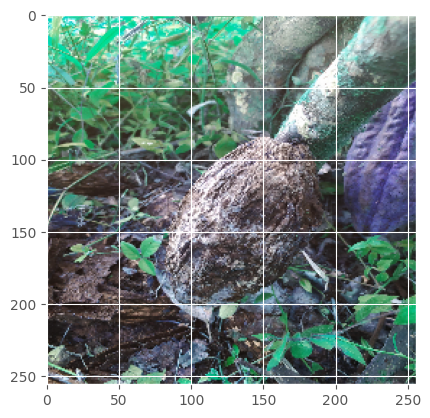

In [61]:
ind = 4
print(images_path[ind])
orig_image = cv2.imread(os.path.join(train_path, images_path[ind]))
orig_image = cv2.resize(orig_image, (256, 256))
plt.imshow(orig_image)

In [62]:
image= np.transpose(orig_image, (2, 0, 1)).astype(np.float32)
image /= 255.0

In [63]:
image = torch.tensor(image, dtype=torch.float).to(DEVICE)
image = torch.unsqueeze(image, 0)
image.shape

torch.Size([1, 3, 256, 256])

In [64]:
with torch.no_grad():
    outputs = model2(image)
len(outputs)

1

In [65]:
outputs[0]
#outputs[0]['boxes'].tolist()

{'boxes': tensor([[206.7559,  46.5220, 255.4928, 155.3195],
         [ 76.4049,  83.8882, 194.2508, 208.4466],
         [ 73.2363,  82.2301, 191.2294, 208.7140]], device='cuda:0'),
 'labels': tensor([3, 1, 3], device='cuda:0'),
 'scores': tensor([0.9978, 0.9904, 0.0837], device='cuda:0')}

In [70]:
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
boxes = outputs[0]['boxes'].data.numpy()
scores = outputs[0]['scores'].data.numpy()
# filter out boxes according to `detection_threshold`
boxes = boxes[scores >= detection_threshold].astype(np.int32)
boxes = [list(box) for box in boxes]
# get all the predicited class names
pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()[scores >= detection_threshold]]
boxes, pred_classes

([[206, 46, 255, 155], [76, 83, 194, 208]], ['Sana', 'Fitoftora'])

In [72]:
str(pred_classes), str(boxes)

("['Sana', 'Fitoftora']", '[[206, 46, 255, 155], [76, 83, 194, 208]]')

In [56]:
detection_threshold = 0.70

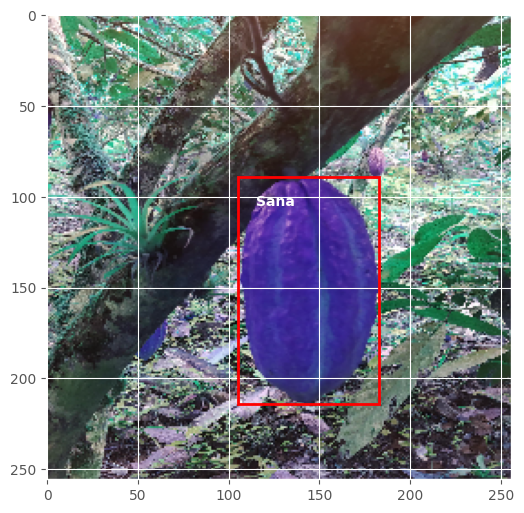

In [57]:
fig, ax = plt.subplots(figsize = (6,9))
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
# carry further only if there are detected boxes
if len(outputs[0]['boxes']) != 0:

    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # get all the predicited class names
    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()[scores >= detection_threshold]]

    # draw the bounding boxes and write the class name on top of it
    for j, box in enumerate(draw_boxes):
        text_red = list([0,0,255])
        text_green = list([50,255,10])
        text_color = list([255,0,0])
        if pred_classes[j] == CLASSES[1]:
            text_color = text_red
        if pred_classes[j] == CLASSES[2]:
            text_color = text_green
        x = (int(box[0]) - int(box[2])*0.5) *orig_image.shape[0]
        y = (int(box[1]) - int(box[3])*0.5) *orig_image.shape[1]
        w = int(box[2]) * orig_image.shape[0]
        h = int(box[3]) * orig_image.shape[1]
        #ax.add_patch(patches.Rectangle((x, y),w,h, fill=False, edgecolor='red', lw=2))
        ax.add_patch(patches.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], fill=False, edgecolor='red', lw=2))
        ax.text(box[0]+10, box[1]+10, pred_classes[j], verticalalignment='top', color='white', fontsize=10, weight='bold')

        #cv2.rectangle(orig_image, , (int(box[2]), int(box[3])), (0, 0, 255), 2)
        #ax.add_patch(patches.Rectangle((int(box[0]), int(box[1])),int(box[2]), int(box[3]), fill=False, edgecolor='red', lw=2))
        # cv2.putText(orig_image, pred_classes[j], 
        #             (int(box[0])+10, int(box[1]+20)),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.9, (text_color), 
        #             2, lineType=cv2.LINE_AA)
        # cv2.putText(orig_image, str("{:.2f}".format(scores[j])), 
        #             (int(box[0])+10, int(box[1]+55)),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.90, (255, 20, 20), 
        #             1, lineType=cv2.LINE_AA)

    ax.imshow(orig_image)

In [3]:
 import numpy as np
 np.random.randn(20, 3).shape

(20, 3)